In [1]:
!pip install --upgrade open_spiel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 19.0 MB/s eta 0:00:00


Game value after step 0 for EINR is 1.25 and for CFR is 1.25


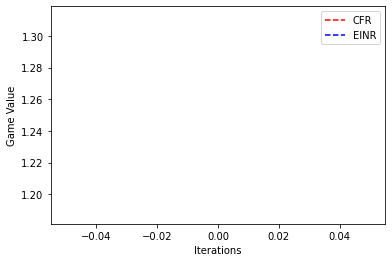

Game value after step 1 for EINR is 4.0 and for CFR is 4.0


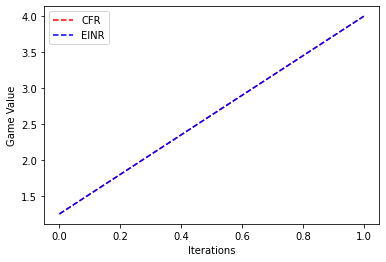

Game value after step 2 for EINR is 4.0 and for CFR is 4.0


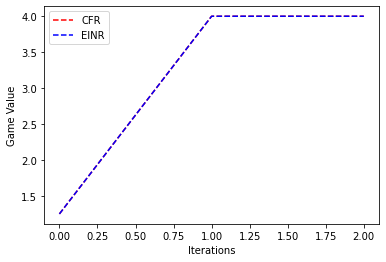

Game value after step 3 for EINR is 4.0 and for CFR is 4.0


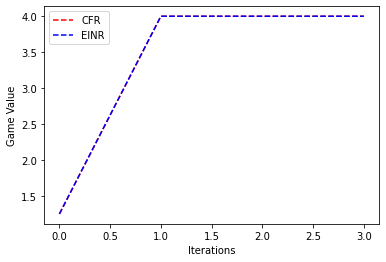

Game value after step 4 for EINR is 4.0 and for CFR is 4.0


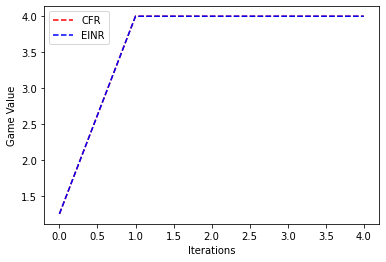

Game value after step 5 for EINR is 4.0 and for CFR is 4.0


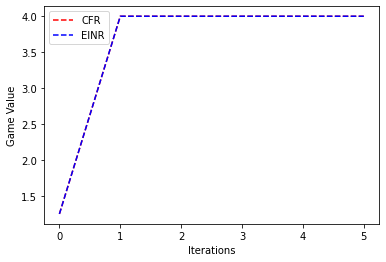

Game value after step 6 for EINR is 4.0 and for CFR is 4.0


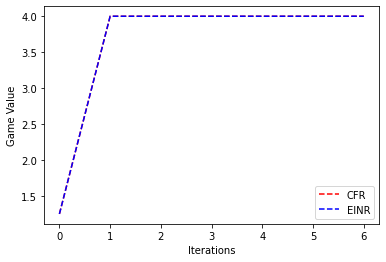

Game value after step 7 for EINR is 4.0 and for CFR is 4.0


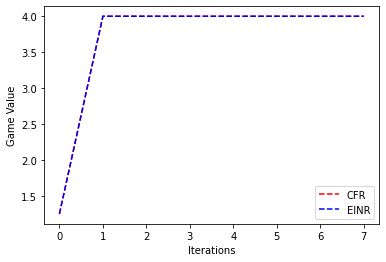

Game value after step 8 for EINR is 4.0 and for CFR is 4.0


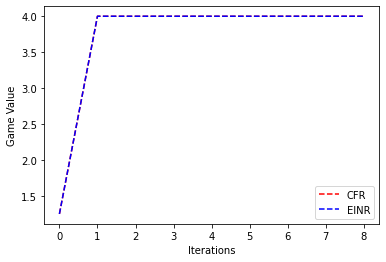

Game value after step 9 for EINR is 4.0 and for CFR is 4.0


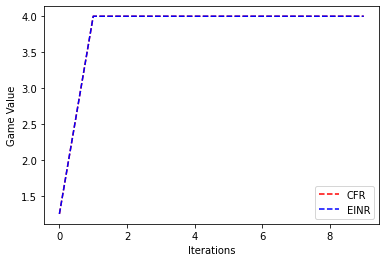

In [ ]:
import itertools as it
from matplotlib import pyplot as plt
import numpy as np
import pyspiel
from os import stat_result
import random 
import math
import sys
import numpy
import matplotlib.pyplot as plt

from open_spiel.python.algorithms import exploitability
from open_spiel.python import policy as policy_lib

np.set_printoptions(precision=10, suppress=True, floatmode='fixed')

#########################################
# Code for EINR and CFR
#########################################

# Storage for logits
terminals_einr = dict()

def new_reach(so_far, player, action_prob):
  """Returns new reach probabilities."""
  new = np.array(so_far)
  new[player] *= action_prob
  return new

##################################
### CFR (Credit: Openspiel)
##################################
def calc_cfr(state, reach):
  """Updates regrets; returns utility for all players."""
  if state.is_terminal():
    returns = [state.returns()[0]*10000, state.returns()[1]*10000]
    return returns
    #return state.returns()
  elif state.is_chance_node():
    print("Should not be called.")
    return sum(prob * calc_cfr(state.child(action), new_reach(reach, -1, prob))
               for action, prob in state.chance_outcomes())
  else:
    # We are at a player decision point.
    player = state.current_player()
    index = policy.state_index(state)
    
    # Compute utilities after each action, updating regrets deeper in the tree.
    utility = np.zeros((game.num_distinct_actions(), game.num_players()))
    for action in state.legal_actions():
      prob = curr_policy[index][action]
      utility[action] = calc_cfr(state.child(action), new_reach(reach, player, prob))

    # Compute regrets at this state.
    cfr_prob = np.prod(reach[:player]) * np.prod(reach[player+1:])
    value = np.einsum('ap,a->p', utility, curr_policy[index])
    for action in state.legal_actions():
      regrets[index][action] += cfr_prob * (utility[action][player] - value[player])

    # Return the value of this state for all players.
    return value


###################################
### EINR
###################################
def calc_einr(state, reach): 
  """Terminal: Create dict space for logit storage"""
  if state.is_terminal():
    state_string = str(state).strip() # Remove spaces
    state_string = state_string.replace("\n", "") # Remove new lines
    # Create unique state representation string to avoid dict collisions
    state_string = state_string + str(random.randint(0, 10000000000))
    if state_string not in terminals_einr: # Creates storage if first time seeing terminal
      terminals_einr[state_string] = dict()
      terminals_einr[state_string][0] = 0
      terminals_einr[state_string][1] = 0

    # Apply learning rate to returns
    returns = state.returns()
    learning_rate = 100000
    returns[0] *= learning_rate
    returns[1] *= learning_rate 
    
    # Use other players reach probability
    cfr_prob0 = reach[1] 
    cfr_prob1 = reach[0]

    # Track logits at terminals
    terminals_einr[state_string][0] += returns[0] * cfr_prob0  
    terminals_einr[state_string][1] += returns[1] * cfr_prob1
    
    returns = terminals_einr[state_string][0], terminals_einr[state_string][1]
    return returns
   
  # elif state.is_chance_node():
  #   print("Should not be called, no chance nodes exist!")
  #   x = sum(prob * calc_einr(state.child(action), new_reach(reach, -1, prob))[0] for action, prob in state.chance_outcomes()) 
  #   y = sum(prob * calc_einr(state.child(action), new_reach(reach, -1, prob))[1] for action, prob in state.chance_outcomes()) 
  #   return x, y

  else:
    # We are at a player decision point.
    player = state.current_player() # 0 or 1
    index = policy_einr.state_index(state) # indexing into openspiel policy given 'state'

    # Track logits at this state
    player_0_logits = []
    player_1_logits = []

    # Loop through legal actions
    for action in state.legal_actions():
      # Current policy at current state
      prob = curr_policy_einr[index][action]
      # First returned value is player 0, second is for player 1
      fn, sn = calc_einr(state.child(action), new_reach(reach, player, prob))
      
      # Store logits for each action
      player_0_logits.append(fn)
      player_1_logits.append(sn)

      # Store values at correct state (index) and action
      if player == 0:
        regrets_einr[index][action] = fn 
      else:
        regrets_einr[index][action] = sn 
    
    # EINR UPDATE RULE
    # Return logits according to EINR rule.
    if player == 0:
      einr_sum = 0.0
      for x in player_1_logits:
        einr_sum += x

      # Code to keep logits from getting too big and overflowing
      maxlogit = max(player_0_logits)
      player_0_logits = [a - maxlogit for a in player_0_logits]
      player_0_logits = [np.exp(a) for a in player_0_logits]
      newlogit = maxlogit + np.log((1.0 / len(state.legal_actions()))*sum(player_0_logits))

      return newlogit, einr_sum # First returned value is player 0, second is for player 1

    else: 
      einr_sum = 0.0
      for x in player_0_logits:
        einr_sum += x

      # Code to keep logits from getting too big and overflowing
      maxlogit = max(player_1_logits)
      player_1_logits = [a - maxlogit for a in player_1_logits]
      player_1_logits = [np.exp(a) for a in player_1_logits]
      newlogit = maxlogit + np.log((1.0 / len(state.legal_actions()))*sum(player_1_logits))

      return einr_sum, newlogit # First returned value is player 0, second is for player 1
      
# Load simple game created in Gambit
game = pyspiel.load_game("efg_game(filename=test_efg_small2.efg)")
initial_state = game.new_initial_state()
legal_actions = initial_state.legal_actions()

# EINR values
policy_einr = policy_lib.TabularPolicy(game)
initial_state = game.new_initial_state()
curr_policy_einr = policy_einr.action_probability_array.copy()
regrets_einr = np.zeros_like(policy_einr.action_probability_array)
eval_steps = []
eval_nash_conv_einr = []

# CFR values
policy = policy_lib.TabularPolicy(game)
initial_state = game.new_initial_state()
curr_policy = policy.action_probability_array.copy()
regrets = np.zeros_like(policy.action_probability_array)
eval_nash_conv = []

random.seed(100)

for step in range(10):

  if step % 1 == 0:
    
    # EINR 
    nc_einr = exploitability._state_values(initial_state,2,policy_einr)[0]
    eval_steps.append(step)
    eval_nash_conv_einr.append(nc_einr)

    # CFR
    nc = exploitability._state_values(initial_state,2,policy)[0]
    eval_nash_conv.append(nc)
    
    print(f'Game value after step {step} for EINR is {nc_einr} and for CFR is {nc}')
    
    # Plot
    plt.plot(eval_steps, eval_nash_conv, '--r', label='CFR')
    plt.plot(eval_steps, eval_nash_conv_einr,  '--b', label='EINR')
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Game Value')
    plt.show()
  
  
  initial_state = game.new_initial_state()
  calc_einr(initial_state, np.ones(1 + game.num_players()))

  regrets_copy = regrets_einr.copy()
  for x in range(regrets_copy.shape[0]):
    maxval = max(regrets_copy[x]) #get max over row
    regrets_copy[x] -= maxval # subtract maxval from each in row
    regrets_copy[x] = np.exp(regrets_copy[x]) # exponentiate 
  sum_regrets = np.sum(regrets_copy, axis=1, keepdims=True)
  curr_policy_einr = regrets_copy / sum_regrets  

  policy_einr.action_probability_array = curr_policy_einr

  # Compute CFR
  calc_cfr(initial_state, np.ones(1 + game.num_players()))

  # Find the new regret-matching policy
  floored_regrets = np.maximum(regrets, 1e-16)
  sum_floored_regrets = np.sum(floored_regrets, axis=1, keepdims=True)
  curr_policy = floored_regrets / sum_floored_regrets

  # Update the (average) policy
  # lr = 1 / (1 + step) # For average policy
  # policy.action_probability_array *= (1 - lr) # For average policy
  # policy.action_probability_array += curr_policy * lr # For average policy
  policy.action_probability_array = curr_policy
  
 



Game value after step 0 for EINR is 0.6664867401123047 and for CFR is 0.6664867401123047


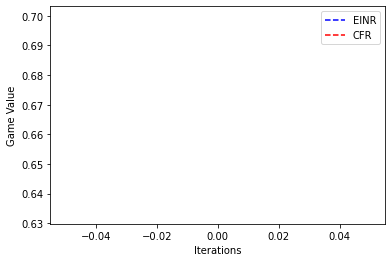

Game value after step 1 for EINR is 1.5753683449236566 and for CFR is 5.999999999370781


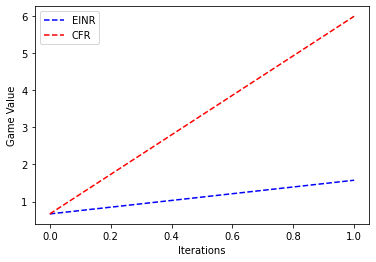

Game value after step 2 for EINR is 2.8862685927904788 and for CFR is 5.999999999370832


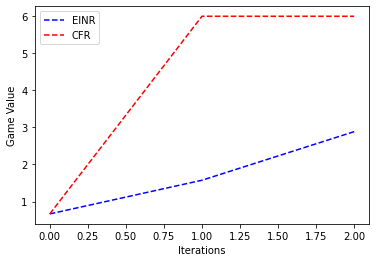

Game value after step 3 for EINR is 4.491901973875602 and for CFR is 5.999999999370892


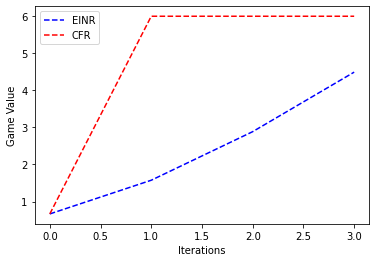

Game value after step 4 for EINR is 11.998236671882596 and for CFR is 5.999999999370941


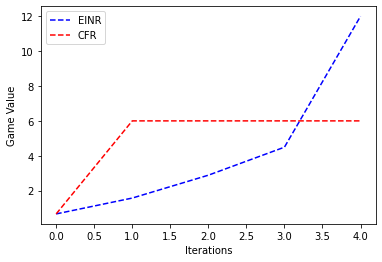

Game value after step 5 for EINR is 12.0 and for CFR is 5.999999999370994


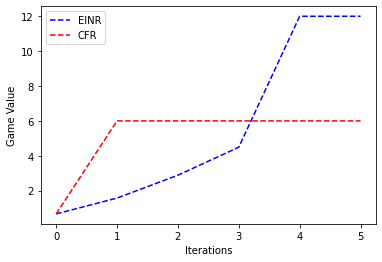

Game value after step 6 for EINR is 12.0 and for CFR is 5.999999999371046


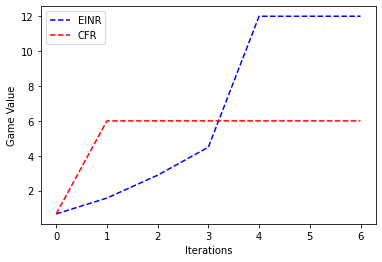

Game value after step 7 for EINR is 12.0 and for CFR is 5.9999999993710995


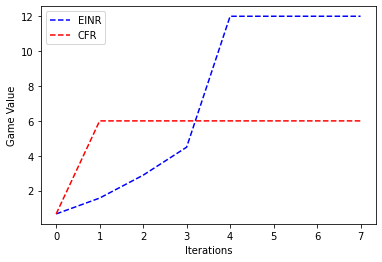

In [16]:
from os import stat_result
import sys
import numpy
import matplotlib.pyplot as plt
import random
import itertools as it
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import pyspiel
from os import stat_result 
import math
from open_spiel.python.algorithms import exploitability
from open_spiel.python import policy as policy_lib
random.seed(100)
#########################################
# EINR for SMGs
#########################################

terminals = dict()

def new_reach(so_far, player, action_prob):
  """Returns new reach probabilities."""
  new = np.array(so_far)
  new[player] *= action_prob
  return new

##################################
### CFR (Credit: Openspiel)
##################################
def calc_cfr(state, reach):
  """Updates regrets; returns utility for all players."""
  if state.is_terminal():
    returns = [state.returns()[0]*1, state.returns()[1]*1]
    return returns
  elif state.is_chance_node():
    return sum(prob * calc_cfr(state.child(action), new_reach(reach, -1, prob))
               for action, prob in state.chance_outcomes())
  else:
    # We are at a player decision point.
    player = state.current_player()
    index = policy.state_index(state)
    
    # Compute utilities after each action, updating regrets deeper in the tree.
    utility = np.zeros((game.num_distinct_actions(), game.num_players()))
    for action in state.legal_actions():
      prob = curr_policy[index][action]
      utility[action] = calc_cfr(state.child(action), new_reach(reach, player, prob))

    # Compute regrets at this state.
    cfr_prob = np.prod(reach[:player]) * np.prod(reach[player+1:])
    value = np.einsum('ap,a->p', utility, curr_policy[index])


    for action in state.legal_actions():
      regrets[index][action] += cfr_prob * (utility[action][player] - value[player])

    return value


##################################
### EINR
##################################
def calc_einr(state, reach): 
  """Updates regrets; returns utility for all players."""
  if state.is_terminal():
    state_string = str(state).strip() # Remove spaces
    state_string = state_string.replace("\n", "") # Remove new lines
    # Create unique state representation to avoid dict collisions
    if state_string not in terminals: 
      terminals[state_string] = dict()
      terminals[state_string][0] = 0
      terminals[state_string][1] = 0

    returns = state.returns()

    # Apply learning rate
    learning_rate = 10
    cfr_prob0 = reach[1] * learning_rate
    cfr_prob1 = reach[0] * learning_rate

    # Track logits at terminals
    terminals[state_string][0] += returns[0] * cfr_prob0
    terminals[state_string][1] += returns[1] * cfr_prob1

    returns = terminals[state_string][0], terminals[state_string][1]
    return returns
   
  elif state.is_chance_node(): # never gets called, ignore
    print("doesn't get calls, no chance nodes should exist.")
    x = sum(prob * calc_einr(state.child(action), new_reach(reach, -1, prob))[0] for action, prob in state.chance_outcomes()) 
    y = sum(prob * calc_einr(state.child(action), new_reach(reach, -1, prob))[1] for action, prob in state.chance_outcomes()) 
    return x, y

  else:
    # We are at a player decision point.
    player = state.current_player() # 0 or 1
    index = policy_einr.state_index(state) # index into openspiel policy


    player_0_logits = []
    player_1_logits = []

    # Accumulate logits 
    for action in state.legal_actions():
      prob = curr_policy_einr[index][action]
      fn, sn = calc_einr(state.child(action), new_reach(reach, player, prob))
      player_0_logits.append(fn)
      player_1_logits.append(sn)
      
    # Apply EINR update rule
    if player == 1:
      return player_0_logits, player_1_logits
    else:

      # Bookkeeping: returned values not always a list
      if not isinstance(player_0_logits[0], list):
        player_0_logits[0] = [player_0_logits[0]]
        player_0_logits[1] = [player_0_logits[1]]

      if not isinstance(player_1_logits[0], list):
        player_1_logits[0] = [player_1_logits[0]]
        player_1_logits[1] = [player_1_logits[1]]

      ##V0 = 1.0
      V0 = 0.0
      for action,x in enumerate(player_0_logits):
        ##V0 *= sum(x)#np.exp(sum(x))
        V0 += np.exp(sum(x))
        regrets_einr[index][action] = sum(x)
      V0 = np.log(V0 / len(state.legal_actions()))
      ##V0 = V0 - np.log(len(state.legal_actions()))

      next_state = state.child(state.legal_actions()[0])
      if not next_state.is_terminal():
        index = policy_einr.state_index(next_state)
      
      ##V1_sum = 1.0
      V1_sum = 0.0
      for action in next_state.legal_actions():
        V1 = 0.0
        for x in range(len(player_1_logits)):
          V1 += player_1_logits[x][action]
        ##V1_sum *= V1
        V1_sum += np.exp(V1)
        if not next_state.is_terminal():
          regrets_einr[index][action] = V1

      V1_sum = np.log(V1_sum / len(state.legal_actions()))
      ##V1_sum = V1_sum - np.log(len(state.legal_actions())) #np.log(V1_sum / len(state.legal_actions()))
      return V0, V1_sum


game = pyspiel.load_game("efg_game(filename=repeated_game.efg)")

initial_state = game.new_initial_state()
legal_actions = initial_state.legal_actions()

# EINR values
policy_einr = policy_lib.TabularPolicy(game)
initial_state = game.new_initial_state()
curr_policy_einr = policy_einr.action_probability_array.copy()
regrets_einr = np.zeros_like(policy_einr.action_probability_array)
eval_steps = []
eval_nash_conv_einr = []

# CFR values
policy = policy_lib.TabularPolicy(game)
initial_state = game.new_initial_state()
curr_policy = policy.action_probability_array.copy()
regrets = np.zeros_like(policy.action_probability_array)
eval_nash_conv = []

for step in range(8):

  if step+1:
    
    # Calculate game value of EINR
    nc_einr = exploitability._state_values(initial_state,2,policy_einr)[0]
    eval_steps.append(step)
    eval_nash_conv_einr.append(nc_einr)

    # Calculate game value of CFR
    nc = exploitability._state_values(initial_state,2,policy)[0]
    eval_nash_conv.append(nc)

    print(f'Game value after step {step} for EINR is {nc_einr} and for CFR is {nc}')

    plt.plot(eval_steps, eval_nash_conv_einr,  '--b', label='EINR')
    plt.plot(eval_steps, eval_nash_conv, '--r', label='CFR')
    plt.legend()
  
    plt.xlabel('Iterations')
    plt.ylabel('Game Value')
    
    plt.show()

  
  initial_state = game.new_initial_state()

  # EINR
  calc_einr(initial_state, np.ones(1 + game.num_players()))

  regrets_copy = regrets_einr.copy()
  for x in range(regrets_copy.shape[0]):
    maxval = max(regrets_copy[x]) 
    regrets_copy[x] -= maxval
    regrets_copy[x] = np.exp(regrets_copy[x])
  sum_regrets = np.sum(regrets_copy, axis=1, keepdims=True)
  
  curr_policy_einr = regrets_copy / sum_regrets  
  policy_einr.action_probability_array = curr_policy_einr

  # CFR
  calc_cfr(initial_state, np.ones(1 + game.num_players()))

  # Find the new regret-matching policy for CFR
  floored_regrets = np.maximum(regrets, 1e-16)
  sum_floored_regrets = np.sum(floored_regrets, axis=1, keepdims=True)
  curr_policy = floored_regrets / sum_floored_regrets

  # Update the average policy for CFR
  lr = 1 / (1 + step)
  policy.action_probability_array *= (1 - lr)
  policy.action_probability_array += curr_policy * lr
  # policy.action_probability_array = curr_policy # Or use current policy
  

In [29]:
import itertools as it
from matplotlib import pyplot as plt
import numpy as np
import pyspiel
from os import stat_result
import random 
import math
import sys
import numpy
import matplotlib.pyplot as plt

from open_spiel.python.algorithms import exploitability
from open_spiel.python import policy as policy_lib

np.set_printoptions(precision=10, suppress=True, floatmode='fixed')

#########################################
# Code for EINR and CFR
#########################################

# Storage for logits
terminals_einr = dict()

def new_reach(so_far, player, action_prob):
  """Returns new reach probabilities."""
  new = np.array(so_far)
  new[player] *= action_prob
  return new

##################################
### CFR (Credit: Openspiel)
##################################
def calc_cfr(state, reach):
  """Updates regrets; returns utility for all players."""
  if state.is_terminal():
    returns = [state.returns()[0]*1, state.returns()[1]*1]
    return returns
    #return state.returns()
  elif state.is_chance_node():
    #print("Should not be called.")
    return sum(prob * calc_cfr(state.child(action), new_reach(reach, -1, prob))
               for action, prob in state.chance_outcomes())
  else:
    # We are at a player decision point.
    player = state.current_player()
    index = policy.state_index(state)
    
    # Compute utilities after each action, updating regrets deeper in the tree.
    utility = np.zeros((game.num_distinct_actions(), game.num_players()))
    for action in state.legal_actions():
      prob = curr_policy[index][action]
      utility[action] = calc_cfr(state.child(action), new_reach(reach, player, prob))

    # Compute regrets at this state.
    cfr_prob = np.prod(reach[:player]) * np.prod(reach[player+1:])
    value = np.einsum('ap,a->p', utility, curr_policy[index])
    for action in state.legal_actions():
      regrets[index][action] += cfr_prob * (utility[action][player] - value[player])

    # Return the value of this state for all players.
    return value


###################################
### EINR
###################################
def calc_einr(state, reach, player): 
  """Terminal: Create dict space for logit storage"""
  if state.is_terminal():
    state_string = str(state).strip() # Remove spaces
    state_string = state_string.replace("\n", "") # Remove new lines
    # Create unique state representation string to avoid dict collisions
    state_string = state_string + str(random.randint(0, 10000000000))
    if state_string not in terminals_einr: # Creates storage if first time seeing terminal
      terminals_einr[state_string] = dict()
      terminals_einr[state_string][0] = 0
      terminals_einr[state_string][1] = 0

    # Apply learning rate to returns
    returns = state.returns()
    learning_rate = 1
    returns[0] *= learning_rate
    returns[1] *= learning_rate 
    
    # Use other players reach probability
    cfr_prob0 = reach[1] 
    cfr_prob1 = reach[0]

    # Track logits at terminals
    terminals_einr[state_string][0] += returns[0] * cfr_prob0  
    terminals_einr[state_string][1] += returns[1] * cfr_prob1
    
    returns = terminals_einr[state_string][0], terminals_einr[state_string][1]
    return returns
   
  elif state.is_chance_node():
    #print("Should not be called, no chance nodes exist!")
    x = sum(prob * calc_einr(state.child(action), new_reach(reach, -1, prob))[0] for action, prob in state.chance_outcomes()) 
    y = sum(prob * calc_einr(state.child(action), new_reach(reach, -1, prob))[1] for action, prob in state.chance_outcomes()) 
    return x, y

  else:
    # We are at a player decision point.
    player = state.current_player() # 0 or 1
    index = policy_einr.state_index(state) # indexing into openspiel policy given 'state'

    # Track logits at this state
    player_0_logits = []
    player_1_logits = []

    # Loop through legal actions
    for x,action in enumerate(state.legal_actions()):
      # Current policy at current state
      prob = curr_policy_einr[index][action]
      # First returned value is player 0, second is for player 1
      fn, sn = calc_einr(state.child(action), new_reach(reach, player, prob))
      
      # Store logits for each action
      player_0_logits.append(fn)
      player_1_logits.append(sn)

      # Store values at correct state (index) and action
      if player == 0:
        regrets_einr[index][action] = fn 
      else:
        regrets_einr[index][action] = sn 
    


    # EINR UPDATE RULE
    # Return logits according to EINR rule.
    if player == 0:
      einr_sum = 0.0
      for x in player_1_logits:
        einr_sum += x

      # Code to keep logits from getting too big and overflowing
      maxlogit = max(player_0_logits)
      player_0_logits = [a - maxlogit for a in player_0_logits]
      player_0_logits = [np.exp(a) for a in player_0_logits]
      newlogit = maxlogit + np.log((1.0 / len(state.legal_actions()))*sum(player_0_logits))

      return newlogit, einr_sum # First returned value is player 0, second is for player 1

    else: 
      einr_sum = 0.0
      for x in player_0_logits:
        einr_sum += x

      # Code to keep logits from getting too big and overflowing
      maxlogit = max(player_1_logits)
      player_1_logits = [a - maxlogit for a in player_1_logits]
      player_1_logits = [np.exp(a) for a in player_1_logits]
      newlogit = maxlogit + np.log((1.0 / len(state.legal_actions()))*sum(player_1_logits))

      return einr_sum, newlogit # First returned value is player 0, second is for player 1
      
# Load simple game created in Gambit
#game = pyspiel.load_game("efg_game(filename=test_efg_small2.efg)")
game = pyspiel.load_game("kuhn_poker")
initial_state = game.new_initial_state()
legal_actions = initial_state.legal_actions()

# einr values
policy_einr = policy_lib.TabularPolicy(game)
initial_state = game.new_initial_state()
curr_policy_einr = policy_einr.action_probability_array.copy()
regrets_einr = np.zeros_like(policy_einr.action_probability_array)
eval_steps = []
eval_nash_conv_einr = []

# CFR values
policy = policy_lib.TabularPolicy(game)
initial_state = game.new_initial_state()
curr_policy = policy.action_probability_array.copy()
regrets = np.zeros_like(policy.action_probability_array)
eval_nash_conv = []

from open_spiel.python.algorithms import sequence_form_utils

# policy_to_sequence
(_, infoset_actions_to_seq, infoset_action_maps, _, _, _) = sequence_form_utils.construct_vars(game)
seq_form = sequence_form_utils.policy_to_sequence(game, policy_einr, infoset_actions_to_seq)
print(seq_form)
#print(policy)

random.seed(100)

for step in range(0):#1000):

  if step % 1 == 0:
    
    # EINR 
    policy_einr = sequence_form_utils.sequence_to_policy(seq_form, game, infoset_actions_to_seq, infoset_action_maps)
    nc_einr = exploitability._state_values(initial_state,2,policy_einr)[0]
    #nc_einr = exploitability.nash_conv(game, policy_einr)
    eval_steps.append(step)
    eval_nash_conv_einr.append(nc_einr)

    # CFR
    nc = exploitability.nash_conv(game, policy)
    #nc = exploitability._state_values(initial_state,2,policy)[0]
    eval_nash_conv.append(nc)
    
    print(f'Game value after step {step} for EINR is {nc_einr} and for CFR is {nc}')
    
    # Plot
    plt.plot(eval_steps, eval_nash_conv, '--r', label='CFR')
    plt.plot(eval_steps, eval_nash_conv_einr,  '--b', label='EINR')
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Game Value')
    plt.show()
  
  
  initial_state = game.new_initial_state()
  calc_einr(initial_state, np.ones(1 + game.num_players()), 0)

  calc_einr(initial_state, np.ones(1 + game.num_players()), 1)

  regrets_copy = regrets_einr.copy()
  for x in range(regrets_copy.shape[0]):
    maxval = max(regrets_copy[x]) #get max over row
    regrets_copy[x] -= maxval # subtract maxval from each in row
    regrets_copy[x] = np.exp(regrets_copy[x]) # exponentiate 
  sum_regrets = np.sum(regrets_copy, axis=1, keepdims=True)
  curr_policy_einr = regrets_copy / sum_regrets  

  policy_einr.action_probability_array = curr_policy_einr

  # Compute CFR
  calc_cfr(initial_state, np.ones(1 + game.num_players()))

  # Find the new regret-matching policy
  floored_regrets = np.maximum(regrets, 1e-16)
  sum_floored_regrets = np.sum(floored_regrets, axis=1, keepdims=True)
  curr_policy = floored_regrets / sum_floored_regrets

  # Update the (average) policy
  lr = 1 / (1 + step) # For average policy
  policy.action_probability_array *= (1 - lr) # For average policy
  policy.action_probability_array += curr_policy * lr # For average policy
  #policy.action_probability_array = curr_policy
  
 



[array([1.0000000000, 0.5000000000, 0.2500000000, 0.2500000000,
       0.5000000000, 0.5000000000, 0.2500000000, 0.2500000000,
       0.5000000000, 0.5000000000, 0.2500000000, 0.2500000000,
       0.5000000000]), array([1.0000000000, 0.5000000000, 0.5000000000, 0.5000000000,
       0.5000000000, 0.5000000000, 0.5000000000, 0.5000000000,
       0.5000000000, 0.5000000000, 0.5000000000, 0.5000000000,
       0.5000000000])]
